# Overview

This week we'll talk about advanced network measures (beyond the degree distribution). We will use these tools to make sense of the network of the Comics Characters on Wikipedia. 
This is the outline for today:

* Visualization and qualitative analysis of the Comic Book Characters Network
* Properties of the network structure, including how univere-origin and other properties shape the network

> _Reading_: This week, the reading is mostly for reference. It's for you to have a place to go, if you want more detailed information about the topics that I cover in the video lectures. Thus, I recommend you check out **Chapter 9** of the network science book. In particular, we'll delve into [Section 9.4](http://networksciencebook.com/chapter/9#modularity) in the exercises below. We will also talk a little bit about degree correlations - you can read about those in [Chapter 7](http://networksciencebook.com/chapter/7)\.

## The informal intro

Today I talk about 
* The exercises for today. 
* How great Slack has been this year and secrets to using it.

Plain and simple. No additional practical information.

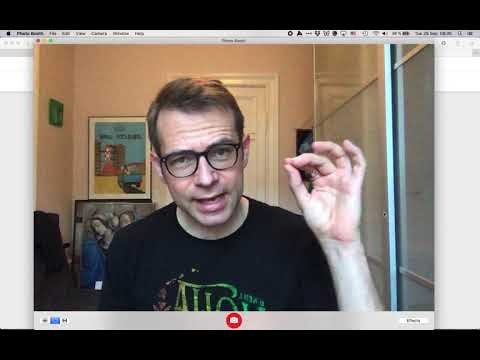

In [1]:
from IPython.display import YouTubeVideo
YouTubeVideo("no0d85VS18w",width=800, height=450)

---
# Part A: Let's  visualise!

*Exercise 1*: Build the right graph for visualization. 

We will continue to work with the network from last week, see the lecture for [Week 4](https://nbviewer.jupyter.org/github/socialcomplexitylab/socialgraphs2020/blob/master/lectures/Week4.ipynb) for details. This is important! Actually, in order to continue with the lecture, you *need* to complete Week 4:

In [12]:
import networkx as nx

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import urllib
import json
import os
import re

sns.set()

In [13]:
df_marvel = pd.read_csv('marvel_characters.csv',sep ='|')
df_marvel = df_marvel.iloc[:,[1,2]]

In [14]:
df_dc = pd.read_csv('dc_characters.csv',sep ='|')
df_dc = df_dc.iloc[:,[1,2]]
df_dc = df_dc.rename(columns = {'WikiLink;':'WikiLink'}, inplace = False)
df_dc['WikiLink'] = df_dc['WikiLink'].str.strip(';')

>1. Use NetworkX `DiGraph` to store the network of characters. Remember that characters are linked if they have a corresponding link between their Wikipedia contents. 
>   * **Additionally**, extract the largest component - it will make our work with visualisations much easier (note: removing *isolated* nodes (with no links) does not guarantee that you are left with the largest component).
>     - *Note 1*: You probably have the right graph if you have more than 2k nodes and more than 15k edges.
>     - *Note 2*: For directed graphs use `weakly connected component` to extract the largest component.
>     - *Note 3*: Further analysis is done with the largest component

In [15]:
import networkx as nx

# Create the Comics network as a directed graph
comics_graph = nx.DiGraph()

In [16]:
# Add nodes and with data (character name & universe)

# For MARVEL
for character_name in df_marvel['CharacterName']:
    comics_graph.add_node(character_name)
     
    # define universe
    comics_graph.nodes[character_name]['universe'] = 'marvel'
    
# For DC
for character_name in df_dc['CharacterName']:
    comics_graph.add_node(character_name)

    # define universe
    comics_graph.nodes[character_name]['universe'] = 'dc'

>2. As you build the graph, store the attributes of the nodes (remember the `universe` from the past week). On top of that, let's also store the `length of the content` as one of the attributes of the node (i.e. count the number of *words* you have in each character's page). By storing this information as nodal features, we keep all the relevant data in one place. The safe way to count words without counting symbols is to use `regex`, but simpler methods are OK.

In [17]:
# Funtion for adding the links/references between the characters to the graph
def link_input(df, path_name, graph):
    for character_name_in in df['CharacterName']:

        # Load the page of the superhero, in a try-except clause for error catching
        try:
            with open(path_name + character_name_in + '.txt', 'r', encoding = 'utf8') as wiki_page:
                page = wiki_page.read()

            # Get all the reference links on the page (using regex)
            links = re.findall('\[{2}((?!.+?:)([^\]\[]+)\|([^\]\[]+)|([^\|]+?))\]{2}', page)
            reference_links = [(tuple(int(x) if x.isdigit() else x for x in _ if x)) for _ in links]

            for i in range(len(reference_links)):

                for character_name_out in df['CharacterName']:
                    if character_name_out == reference_links[i][0]:
                        # Add edge 1 by 1
                        graph.add_edge(character_name_in, reference_links[i][0])
        except:
            pass
        
    return graph

In [18]:
comics_graph = link_input(df = df_dc, path_name = './data/dc/', graph = comics_graph)
comics_graph = link_input(df = df_marvel, path_name = './data/marvel/', graph = comics_graph)

In [19]:
# Remove the isolated nodes from the graph
comics_graph.remove_nodes_from(list(nx.isolates(comics_graph)))

In [20]:
for component in list(nx.connected_components(comics_graph.to_undirected())):
    if (len(component) < 5):
        for node in component:
            comics_graph.remove_node(node)

*Exercise 2:* Let's build a simple visualization of network
>1. For the sake of the visualisation, let's convert our network to *undirected graph* (tip: There is a NetworkX command to help you).
>   * *Note*: Keep the directed graph, we will use it in couple of the following exercises

In [21]:
# Create the undirected version of the Comics universe graph
comics_graph = comics_graph.to_undirected()

>2. Use the NetworkX command `nx.draw_kamada_kawai` to draw the network resulting undirected. (You can find [background on the algorithm here](https://en.wikipedia.org/wiki/Force-directed_graph_drawing).)  
>   * Node color should depend on the `universe` attribute (i.e. use different colors for DC and Marvel universe)
>   * Set up your plot so that node-size depends on the node *degree*
>   * **Optional**: Set up you plot so that edge color depends on the `universe` attribute. If an edge connects two nodes from Marvel universe assign `color_a`, if the edge connects two nodes from DC universe assign `color_b`, in case a link connects nodes from disparate universes, cases assign `color_c`. (Here, you get to decide on the colors.)

*Exercise 3:* We can make even better visualisations with `ForceAtlas2` package
>1. The [Force Atlas 2 algorithm](https://github.com/bhargavchippada/forceatlas2) helps calculate more aesthetically pleasing positions for the nodes (see what the result looks like below).
>2.You can install the  package typing `pip install fa2` in the terminal. The [github page](https://github.com/bhargavchippada/forceatlas2) explains how to use the package to get coordinates for each node.
> * Visualize the network using the [Networkx draw function](https://networkx.github.io/documentation/stable/reference/generated/networkx.drawing.nx_pylab.draw.html#networkx.drawing.nx_pylab.draw), and node-coordinates from the force atlas algorithm. As in the previous Exercise:
>   * Node color should depend on the `universe` attribute (i.e. use different colors for DC and Marvel universe)
>   * Node size should depend on the node *degree*
>   * **Optional**: Edge colour should depend on the `universe` attribute. If an edge connects nodes from Marvel universe assign `color_a`, if the edge connects nodes from DC universe assign `color_b`, in other cases assign `color_c`

In [23]:
from fa2 import ForceAtlas2 as FA2

# Create instance for FA2
forceatlas2 = FA2(scalingRatio = 100, gravity = 100)

First of all, let us calculate the most appropriate positions for the nodes of the _undirected_ Comics network graph, using the Force Atlas method:

In [24]:
# Calculate positions of nodes in the visualization
positions = forceatlas2.forceatlas2_networkx_layout(comics_graph.to_undirected(), pos = None, iterations = 1000)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:31<00:00, 10.90it/s]

BarnesHut Approximation  took  12.19  seconds
Repulsion forces  took  76.76  seconds
Gravitational forces  took  0.23  seconds
Attraction forces  took  0.35  seconds
AdjustSpeedAndApplyForces step  took  1.11  seconds


After we have found the most appropriate positions for every node in the graph, let us also make a color according to the universe, as well as, a node scaling based on the universe that the nodes are belonging to:

In [25]:
character_color_dict = {}

# For every node in this community, we assign them the previously-computed random color
for entry in comics_graph.nodes(data = True):
    
    # Extract the data about the node
    name = entry[0]
    universe = entry[1]['universe']
    
    if (universe == 'marvel'):
        character_color_dict[name] = 'gold'
    elif (universe == 'dc'):
        character_color_dict[name] = 'skyblue'
        
# The node colors in the DICT are not in the same order as the nodes in the graph, therefore we need to create a separate list to deal with that
node_colors = []
# At the same time, we will create a list of node sizes by looking directly at the total degree of each individual node
node_sizes = []

for node in comics_graph:
    # Append the appropriate color to a node
    node_colors.append(character_color_dict[node])
    
    # Append the appropriate size to a node
    node_sizes.append(comics_graph.degree(node) * 0.4)

Finally, let us visualize the graph (using the Force-Atlas method):

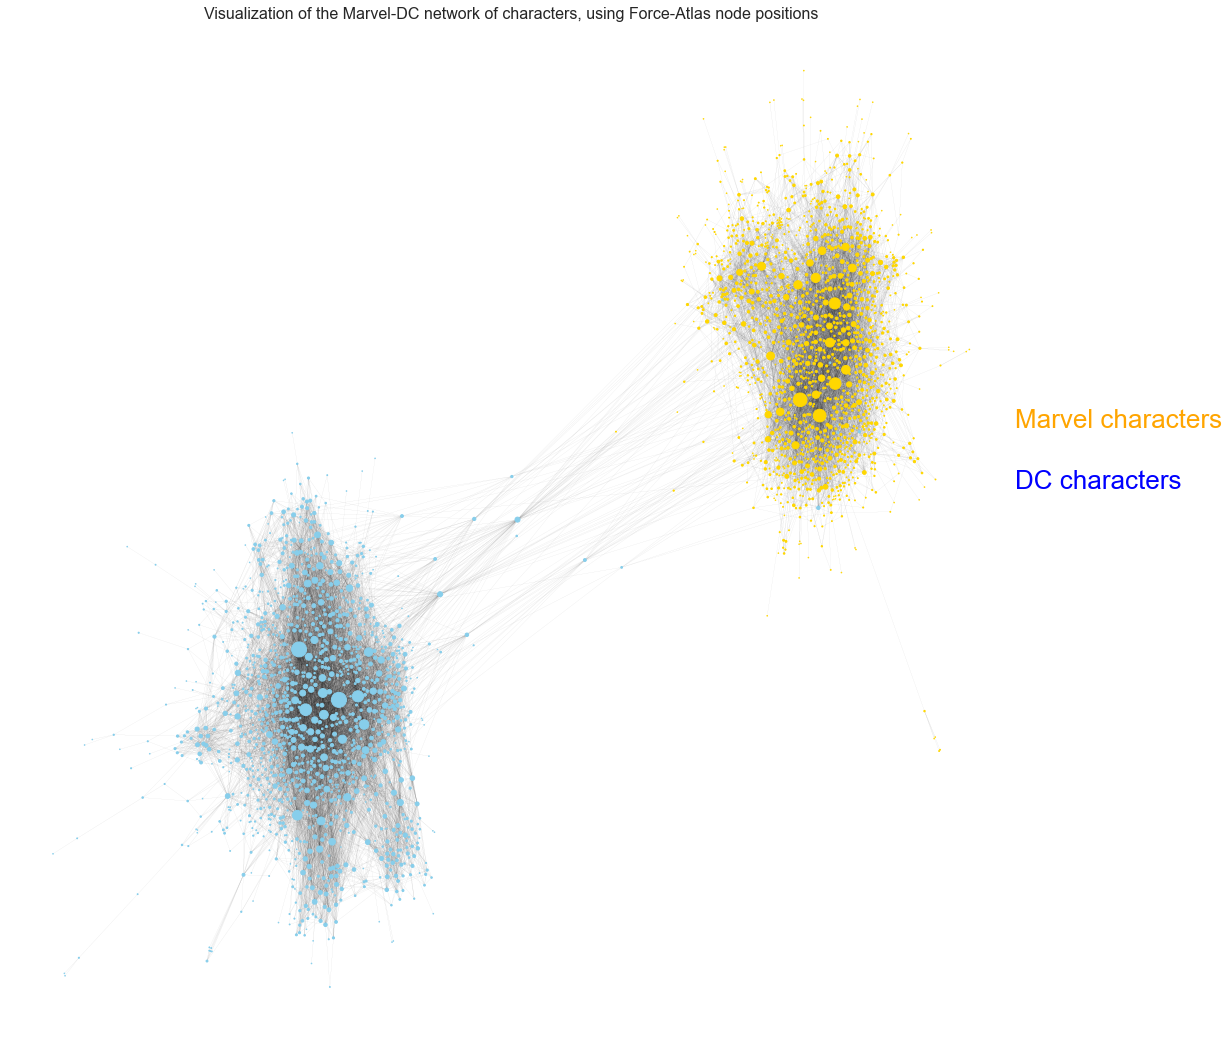

In [26]:
plt.figure(figsize = (14, 14))

nx.draw(comics_graph, pos = positions, node_size = node_sizes, node_color = node_colors, width = 0.025)

plt.figtext(1, 0.60, 'Marvel characters', size = 26, color = 'orange')
plt.figtext(1, 0.54, 'DC characters', size = 26, color = 'blue')

plt.title("Visualization of the Marvel-DC network of characters, using Force-Atlas node positions", fontsize = 16);

> * Play with the force atlas algorithm parameters to obtain a visualization you like. It may look similar to the one below (but not necessarily). 
> * Describe the structure you observe. Can you see that the nodes seperate into two separate clusters? Can you see high-degree nodes? In the plot below, the red nodes seem to split into two sub-clusters: What's going on there?

<span style="color:blue">The visualization has made use of the Force Atlas algorithm in order to spatialize the _undirected_ version of the Comics network, and the positions retrieved from the algorithm have been used here, together with a color and size separation for each individual node/character in the network. We can see that there is indeed a "feeling" of community splitting already from within this full network graph, where most characters from one universe interact only with other members from the same universe.</span>

<span style="color:blue">The black spots in the graph are actually resulting from the directed arrows going into and out of nodes, since the Force-Atlas algorithm does not account for this in its calculations of node positions.</span>

![Network](https://github.com/SocialComplexityLab/socialgraphs2020/blob/master/files/week5_fa2_a.png?raw=true)

*Exercise 4*: We continue with a qualitative inspection of the Wikipedia pages, that will help us to intepret our results. We investigate the reasons for links between characters to exist on Wikipedia.

>1. Consider the nodes with highest in-degree in the network. Open the corresponding Wikipedia page.
>   * Consider the set of neighbours pointing towards the node found above. 
>   * What is the relation between the characters you identified and his/her network neighbours? (e.g. do they appear in the same comics, are they opponents...). You don't need to come up with a grand theory of comics here, I just want you to think about how links com about.
>   * Repeat the exercise for the largest out-degree node. 
>   * Are there differences between reasons for out- and in-links? Again, there's no right answer here. I just want you to think about some of the reasons why links may occur in Wikipedia
>5. Are there any nodes with high out-degree and with few incoming connections? If yes, open WikiPages of such characters and explain what happens?
>6. Are there any nodes with high in-degree and few outcoming connections? Again, open WikiPages of such characters and explain what happens? 

# Part B:  Advanced tools 

> **Video lecture**: *Network measures*. There's an updated video below, and if you can't get enough, you can watch the original version from 2015 [here](https://www.youtube.com/watch?v=0uAYpOqVHCU).

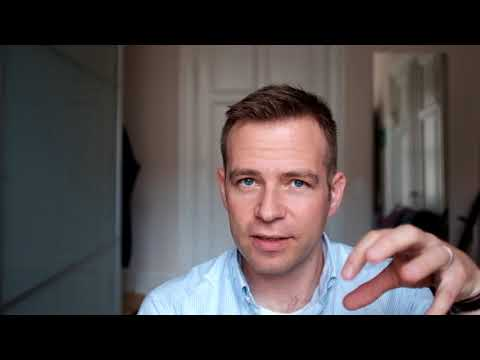

In [2]:
from IPython.display import YouTubeVideo
YouTubeVideo("IOWXZFOyk9Y", width=800, height=450)

*Exercise 1:* Last time we visually analyzed (plotted) the degree distributions of our network. Now, let's analyze it using some of the tools from previous lectures. For this exercise we are going to look at the *directed* graph (rememeber, we asked you to keep one?).

>1. What are the average, median, mode, minimum and maximum value of the in-degree? And of the out-degree? How do you intepret the results?
>    * On top of that, calculate same statistics separately for the network that is spanned only by DC Characters (we call this the DC-network), and only by the Marvel characters (the Marvel-network). How do you interpret the results? 
>2. Let's also look at the *[exponent of the degree distribution](http://networksciencebook.com/chapter/4#degree-exponent)* 
>    * To calculate it, you can install `powerlaw` package (I could not install in conda, so I used `pip install powerlaw`)
>    * Use `powerlaw.Fit(degree).alpha` for fitting
>    * Find the degree exponent for in-, out- and total- degree distribution. What does it say about our network?
>    * When analyzing the plots of in- and out- degree distribution last week, did you come up to the same conclusions?
>    * Some long time ago, couple of scientist have analyzed the network that is spanned by the whole Wikipedia (paper is called [Wikipedias: Collaborative web-based encyclopedias as complex networks](https://journals.aps.org/pre/abstract/10.1103/PhysRevE.74.016115); to access this paper, use findit.dtu.dk or read the preprint on [arXiv](https://arxiv.org/abs/physics/0602149)). Do your findings correspond to the results described in Chapter **III.A**? If not, why? 
>3. Plot a scatter plot of the the in- versus out- degree for all characters. Comment on the relation between the two.
>4. Plot a heatmap [(Hint here)](https://stackoverflow.com/questions/2369492/generate-a-heatmap-in-matplotlib-using-a-scatter-data-set) of the the in- versus out- degree for all characters. What is the advantage of using a heatmap over the scatter plot?
>5. Why do you think I want you guys to use a directed graph? Could have we used an undirected graph instead?
>6. We have one more metric that we did not use. The node-attribute `content lenght`. There are two things we can investigate here.
>   * Firstly, we can verify that more text means more links. If that's true the length should correlate with out-degree.
>   * Secondly, and more interestingly, it could be that longer texts means more famous characters. And that means more in-links. 
>   * How should you test this? Well, here you are allowed to be **creative**. You may choose the method of your liking to study this question (e.g. look at it visually, test the correlation using spearman or pearson, fit a curve to the data, you decide). Once you've tested, let me know. Are both questions true? If yes, which phenomenon is stronger? Explain your results in your own words

*Exercise 2:* Centralities, assortativity and more.

Earlier, we found the most connected nodes (using degree centrality). 

Now let's dig in and try to understand more about the network using more advanced features. 

**Note**: Not all of the measures we'll be considering below are defined for directed graphs. Only use the undirected graph when explicitly stated in the exercise. Meanwhile, **for this exercise use either the DC or Marvel Network alone (i.e. only a single universe). This it will help you to see the differences).**
>1. Find the 5 most central characters according to degree centrality. 
>   * Repeat Exercise A2 or A3 from above for your new sub-network (depending on which visualization method you liked the most), but with our new network.
>1. Find the 5 most central characters according to betweenness centrality. 
>   * Repeat Exercise A2 or A3 (depending on which visualization method you liked the most). However, this time use betweenness centrality to define the size of the node.
>   * What role do you imagine characters with high wikipedia graph betweenness centrality play? 
>2. Find the 5 most central characters according to eigenvector centrality. Calculate centrality corresponding to both in- and out-edges (see NetworkX documentation for details). 
>   * Repeat Exercise A2 or A3 (depending on which visualization method you liked the most). However, this time use eigenvector centrality to define the size of the node.
>   * What role do you imagine characters with high wikipedia graph eigenvector centrality play? 
>3. Plot the betweenness centrality of nodes vs their degree centrality. Is there a correlation between the two? Did you expect that? Why? 
>    * Repeat using eigenvector centrality instead of betweenness centrality. Do you observe any difference relative to above? Why?
>4. Is the undirected version of the graph assortative with respect to degree? (e.g. do high-degree characters tend to link to other high-degree characters, and low-degree characters to other low-degree characters?). Provide an interpretation of your answer.
>4. Is the undirected version of the graph assortative with respect do the `content length` nodal properties? (e.g. do characters with long Wikipedia pages tend to link to other charakters with long Wiki-pages, and *vice versa*?. Hint: Use [this function](https://networkx.github.io/documentation/stable/reference/algorithms/generated/networkx.algorithms.assortativity.attribute_assortativity_coefficient.html#networkx.algorithms.assortativity.attribute_assortativity_coefficient). Provide an interpretation of your answer.
>5. What is the average shortest path length? Is it similar to the one of a random graph with the same number of nodes $N$  and probablity of connection $p$?
>   * Take a look at the *distribution* of shortest paths for the two networks (create a histogram for each network) to better compare and contrast. Explain what you see in your own words.
> * **Optional** (but cool). What about betweenness centrality in the full network? Create a visualization of the network using Force Atlas 2, where you set the size of nodes to scale according to their betweenness centrality. Describe in your own words what you learn from that plot.

*Exercise 3*: Does a universe of a character play a large role? Now, let us explore if and how they shape the network (use full network). 
>1. Compute the average node centrality for Marvel and DC characters respectively (choose your favourite centrality measure). Which universe has the more central characters?
>2. Create a randomized version of the full graph, where the association between nodes and universes is shuffled. Compute the average centrality of DC and Marvel nodes for this randomized graph. 
>   * **Hint**: To create this shuffling, simply give everyone a random universe assignment (but with the same number of Marvel and DC characters as in the real data). The way I usually create random lables is by using either [`random.shuffle`](https://docs.python.org/3/library/random.html#random.shuffle) or [`numpy.random.permutation`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.random.permutation.html).
>3. Repeat the shuffling process above 1000 times (at least) and plot two histograms, each histogram with the 1000 corresponding average values of centrality obtained for Marvel and DC characters in the shuffeled netowrks.
>4. Compare the value you have obtained in the real graph, with the randomized cases. Are characters of one of the two universes more central in the network (on average)?
>5. Think about your results, what could be possible explanations for what you observe?